# Evaluating the performance of the kataegis detection packages

This Jupyter notebook will reproduce the evaluation of kataegis detection packages as detailed within our manuscript.


## Loading/installing dependencies

First, we import the dependencies for this notebook. If the R dependencies are not installed, we install them.


In [ ]:
# Install and load packages for kataegis analysis.
install.packages("librarian")
librarian::shelf(katdetectr, BiocManager, Biobase, eblondel / zen4R, mltools, VennDiagram, futile.logger, ggplot2, dplyr, VariantAnnotation, pbapply, SeqKat, doMC, ClusteredMutations, kataegis, maftools, flosalbizziae / kataegis)

# Set the seed for reproducibility
set.seed(1)

### Setting up SigProfiler dependencies (GRCh37)

Please note that sigprofiler needs to be installed separately.

```python
pip3 install SigProfilerClusters SigProfilerSimulator seaborn
```

In order for SigProfiles to run, we need to download the GRCh37 reference genome and the corresponding annotations.

```bash
python3 ../python/setupSigProfiler.py
```


## Importing Alexandrov et al. (2013) data and generating the synthetic datasets

### Reproducibility

All previously generated input and output for reproduction of the evaluation of kataegis detection packages as detailed within our manuscript were deposited on [Zenodo](https://doi.org/10.5281/zenodo.6810477) to allow re-generating the presented figures and tables. 

This will retrieve all the RData objects using in the latter part of this notebook.


In [ ]:
# Increase the timeout (due to some large files).
options(timeout = 5000)

# Download the required files into the data/reproduction folder (~1GB).
# Skip if files already exist.
if (!dir.exists("data/reproduction")){
    dir.create("data/reproduction", recursive = TRUE, showWarnings = FALSE)
    zen4R::download_zenodo(doi = "10.5281/zenodo.6810477", path = "data/reproduction/", quiet = FALSE, overwrite = FALSE)
}

### Fresh run

#### Importing somatic variants and kataegis calls from Alexandrov et al. (2013)

The following code will download and pre-process the somatic variants and kataegis calls from Alexandrov et al. (2013). This will generate an RData object within the specified `path`.


In [ ]:
source("R/1.importAndProcess_Alexandrov.R")
importAlexandrovData(path = "data/")

### Generating synthetic datasets

The following code will generate a set of synthetic samples (hg19) with varying degrees of kataegis events. This will generate an RData object within the specified `path`.


In [ ]:
source("R/2.importAndProcess_Synthetic.R")
generateSyntheticData(path = "data/")

## Performing the various kataegis-detection packages

Next, we will perform the various R-based kataegis-detection packages (katdetectr, SeqKat, maftools, kataegis and ClusteredMutations) and python-based (SigProfilerClusters) on the same datasets (Alexandrov et al. and the synthetic dataset). This will generate RData objects containing the results within `data/`.


In [ ]:
# Run the R-based tools on the Alexandrov et al. and synthetic datasets.
source("R/3.performRPackages.R")

# Remove the subset argument (or set to FALSE) to perform on all samples.
runTools_Alexandrov(data = "data/alexandrov_data_processed.RData", subset = TRUE)
runTools_Synthetic(data = "data/synthetic_data.RData", subset = TRUE)

In [ ]:
# Run the python-based SigProfiler on the Alexandrov et al. and synthetic datasets.
source("R/4.performSigProfiler.R")
runSigProfiler(dataAlexandrov = "data/alexandrov_data_processed.RData", dataSynthetic = "data/synthetic_data.RData", subset = TRUE)

## Evaluate the results

Finally, we will evaluate the results of the various kataegis-detection packages. This will generate the figures and tables presented within our manuscript.
We begin by loading in all the results from the previous steps.

When the data is downloaded from Zenodo to reproduce the exact figures as presented within the manuscript, please change the `data/` path to the path where the RData objects were downloaded (`data/reproduction`).


In [13]:
# Load all required data and functions.
reproduction <- TRUE

if ( reproduction) {
    path <- "data/reproduction/"
    load(file = file.path(path, "parameters_synthetic_data.RData"))
    load(file = file.path(path, "alexandrov_data_processed_WGS_and_WES.RData"))

}else{
    path <- "data/"
    load(file = file.path(path, "resultsAlexandrovAllTools.RData"))
}

# Load data.
load(file = file.path(path, "resultsAlexandrovAllTools.RData"))
load(file = file.path(path, "alexandrov_data_processed.RData"))


load(file = file.path(path, "resultsSyntheticAllTools.RData"))
load(file = file.path(path, "synthetic_data.RData"))


# Load functions.
source(file = "R/function_calculateMetrics.R")
source(file = "R/function_calculateConfusionVariants.R")
source(file = "R/ggplot_theme.R")

# Load sample origin data.
sampleOrigin <- read.csv("misc/sampleOrigin.txt", header = TRUE, sep = "\t")

### Overview of results for Alexandrov et. al (2013).

#### Descriptive overview of kataegis per TMB class.

In [3]:
fociPerSample <- alexandrovData$reportedKataegis |>
    tibble::as_tibble() |>
    dplyr::group_by(.data$sampleNames) |>
    dplyr::summarise(
        nKataegisFoci = dplyr::n()
    )

alexandrovData$genomicVariants |>
    tibble::as_tibble() |>
    dplyr::group_by(.data$sampleNames) |>
    dplyr::summarise(
        .groups = "keep",
        totalVariants = dplyr::n(),
        kataegisVariants = sum(.data$kataegis),
        tissue = unique(.data$tissue)
    ) |>
    dplyr::mutate(
        TMB = base::round(.data$totalVariants / 3095, 3),
        TMBcat = dplyr::case_when(
            TMB < 1 ~ "low",
            TMB >= 1 & TMB < 10 ~ "mid",
            TMB >= 10 ~ "high"
        )
    ) |>
    dplyr::left_join(fociPerSample, by = "sampleNames") |>
    dplyr::mutate(nKataegisFoci = tidyr::replace_na(.data$nKataegisFoci, 0)) |>
    dplyr::group_by(TMBcat) |>
    dplyr::summarise(
        nSample = dplyr::n(),
        nKataegisSamples = base::sum(.data$nKataegisFoci != 0),
        totalVariants = base::sum(.data$totalVariants),
        kataegisVariants = base::sum(.data$kataegisVariants),
        nKataegisFoci = base::sum(.data$nKataegisFoci)
    )

TMBcat nSample nKataegisSamples totalVariants kataegisVariants nKataegisFoci
1 high    20     18               1433353       3107             336          
2 low    301     45                299184        946              93          
3 mid    186     89               1650214       5058             444

#### Combine results into a dataframe and add columns needed for further analysis.

In [15]:
kataegisSampleNames <- base::unique(alexandrovData$reportedKataegisFoci$sampleNames)
nVariantsInSample <- base::lapply(alexandrovData$genomicVariants, base::length)
nVariantsInSampleTib <- tibble::tibble(sampleNames = base::names(nVariantsInSample), totalVariantsInSample = base::unlist(nVariantsInSample))

# combine all results in a single tibble and add columns needed for subsequent analysis
resultsAlex <- dplyr::bind_rows(
    "MafTools" = resultsAlexandrovAllTools$maftools,
    "SeqKat" = resultsAlexandrovAllTools$seqkat,
    "ClusteredMutations" = resultsAlexandrovAllTools$clusteredMutations,
    "Katdetectr" = resultsAlexandrovAllTools$katdetectr,
    "Kataegis" = resultsAlexandrovAllTools$kataegis,
    "SigProfilerClusters" = resultsAlexandrovAllTools$sigProfilerClusters,
    .id = "package"
) |>
    dplyr::distinct() |>
    dplyr::left_join(nVariantsInSampleTib, by = "sampleNames") |>
    dplyr::mutate(
        # calculate tumor mutational burden per sample by total number of variants / (length of the genome / 10^6) ~ 3095
        TMB = base::round(totalVariantsInSample / 3095, 3),
        TMBcat = dplyr::case_when(
            TMB < 1 ~ "low",
            TMB >= 1 & TMB < 10 ~ "mid",
            TMB >= 10 ~ "high"
        ),
        TMBcat = factor(TMBcat, levels = c("high", "mid", "low")),
        # specify if a kataegis foci was detected by the method
        detectedKataegisInSample = dplyr::if_else(is.na(.data$totalVariants), FALSE, TRUE),
        # specify if a sample contains a kataegis foci according to Alexandrov
        kataegisInSample = dplyr::if_else(sampleNames %in% kataegisSampleNames, TRUE, FALSE)
    ) |>
    dplyr::left_join(sampleOrigin, by = "sampleNames")

# Calculate the performance metrics for each method
resultsPerSampleAlex <- resultsAlex |>
    # summarise if a method detected kataegis in a sample
    dplyr::group_by(.data$package, .data$sampleNames, .data$TMB, .data$TMBcat, .data$runTime) |>
    dplyr::summarise(
        .groups = "keep",
        # is a kataegis foci detected by the method
        detectedKataegisInSample = any(detectedKataegisInSample),
        # is there actualy a kataegis foci in that sample
        kataegisInSample = any(kataegisInSample)
    ) |>
    dplyr::ungroup() |>
    dplyr::rowwise() |>
    # calculate confusion matrix
    dplyr::mutate(
        TP = .data$detectedKataegisInSample == TRUE & .data$kataegisInSample == TRUE,
        FP = .data$detectedKataegisInSample == TRUE & .data$kataegisInSample == FALSE,
        TN = .data$detectedKataegisInSample == FALSE & .data$kataegisInSample == FALSE,
        FN = .data$detectedKataegisInSample == FALSE & .data$kataegisInSample == TRUE
    ) |>
    dplyr::ungroup()

performancePerSampleAlex <- resultsPerSampleAlex |>
    dplyr::group_by(.data$package) |>
    dplyr::group_modify(~ calculateMetrics(.x), .keep = TRUE) |>
    dplyr::ungroup()

performancePerSampleTMB <- resultsPerSampleAlex |>
    dplyr::group_by(.data$package, .data$TMBcat) |>
    dplyr::group_modify(~ calculateMetrics(.x), .keep = TRUE) |>
    dplyr::ungroup()

# Calculate the performance of the kataegis detection tools regarding variant classification
resultsPerVariant <- resultsAlex |>
    dplyr::group_by(.data$package, .data$sampleNames) |>
    dplyr::group_modify(~ suppressWarnings(calculateConfusionVariants(.x, variantData = alexandrovData)), .keep = TRUE) |>
    dplyr::ungroup()

performancePerVariantAlex <- resultsPerVariant |>
    dplyr::group_by(.data$package) |>
    dplyr::group_modify(~ suppressWarnings(calculateMetrics(.x)), .keep = TRUE) |>
    dplyr::ungroup() |>
    arrange(desc(nMCC)) |>
    dplyr::select(package, accuracy, nMCC, F1, TPR, TNR)

performancePerVariantTMBAlex <- resultsPerVariant |>
    dplyr::group_by(.data$package, .data$TMBcat) |>
    dplyr::group_modify(~ suppressWarnings(calculateMetrics(.x)), .keep = TRUE) |>
    dplyr::ungroup()

#### Visualize the MMC.

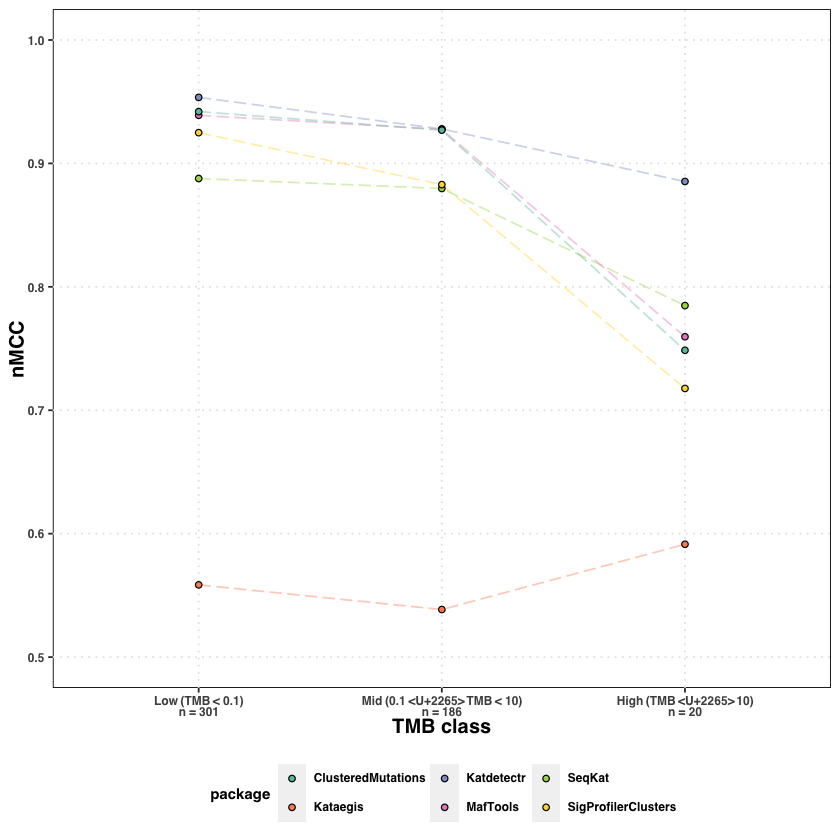

In [16]:
levelOrderTMB <- c("Low (TMB < 0.1)", "Mid (0.1 >= TMB < 10)", "High (TMB >= 10)")
levelOrderTMB <- c("low", "mid", "high")
levelOrderPackages <- factor(performancePerVariantAlex$package, levels = arrange(performancePerVariantAlex, nMCC)$package)

colors <- c("ClusteredMutations" = "#66C2A5", "Kataegis" = "#FC8D62", "Katdetectr" = "#8DA0CB", "MafTools" = "#E78AC3", "SeqKat" = "#A6D854", "SigProfilerClusters" = "#FFD92F")

plotnMMC.Alex <- performancePerVariantTMBAlex |>
    ggplot2::ggplot(ggplot2::aes(x = factor(TMBcat, levels = levelOrderTMB), y = nMCC, group = factor(package, levels = levelOrderPackages), colour = factor(package, levels = levelOrderPackages))) +
    ggplot2::geom_line(linewidth = 0.5, alpha = 0.4, lty = 11) +
    ggplot2::geom_point(ggplot2::aes(x = factor(TMBcat, levels = levelOrderTMB), y = nMCC, fill = package), col = "black", shape = 21, position = ggbeeswarm::position_quasirandom(width = .05)) +
    ggplot2::scale_fill_manual(values = colors) +
    ggplot2::scale_color_manual(values = colors, guide = "none") +
    ggplot2::scale_x_discrete(labels = c(
        "low" = "Low (TMB < 0.1)<br>n = 301",
        "mid" = "Mid (0.1 ≥ TMB < 10)<br>n = 186",
        "high" = "High (TMB ≥ 10)<br>n = 20"
    )) +
    ggplot2::ylim(0.5, 1) +
    ggplot2::labs(x = "TMB class", y = "nMCC") +
    theme_Job

plotnMMC.Alex

#### Visualize performance in variant classification split on TMB.

Warning message:
"Removed 2 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_half_point_panel()`)."


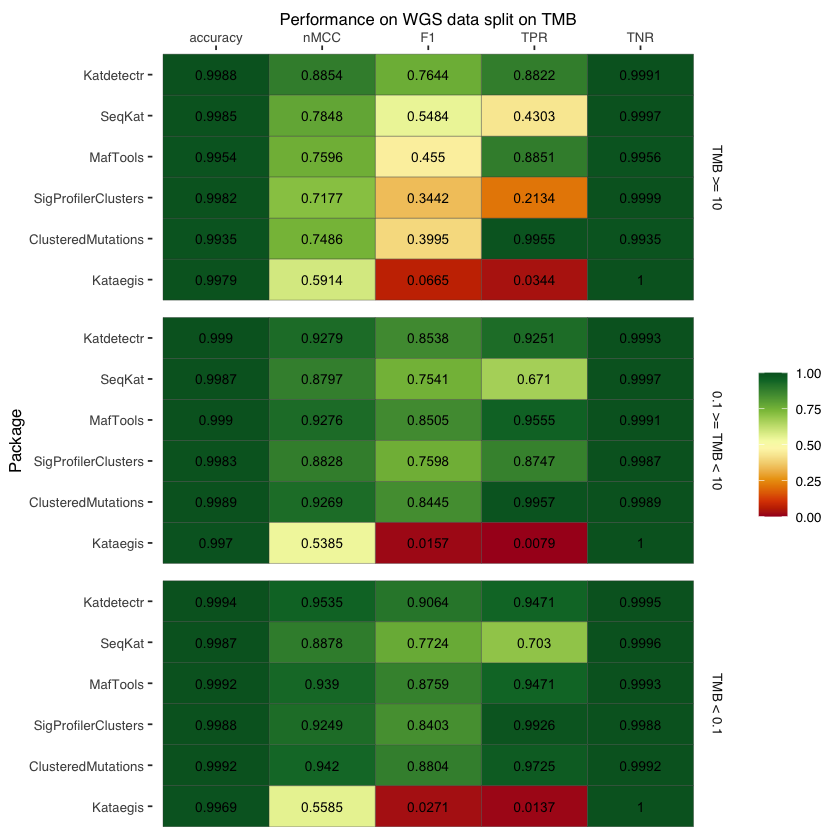

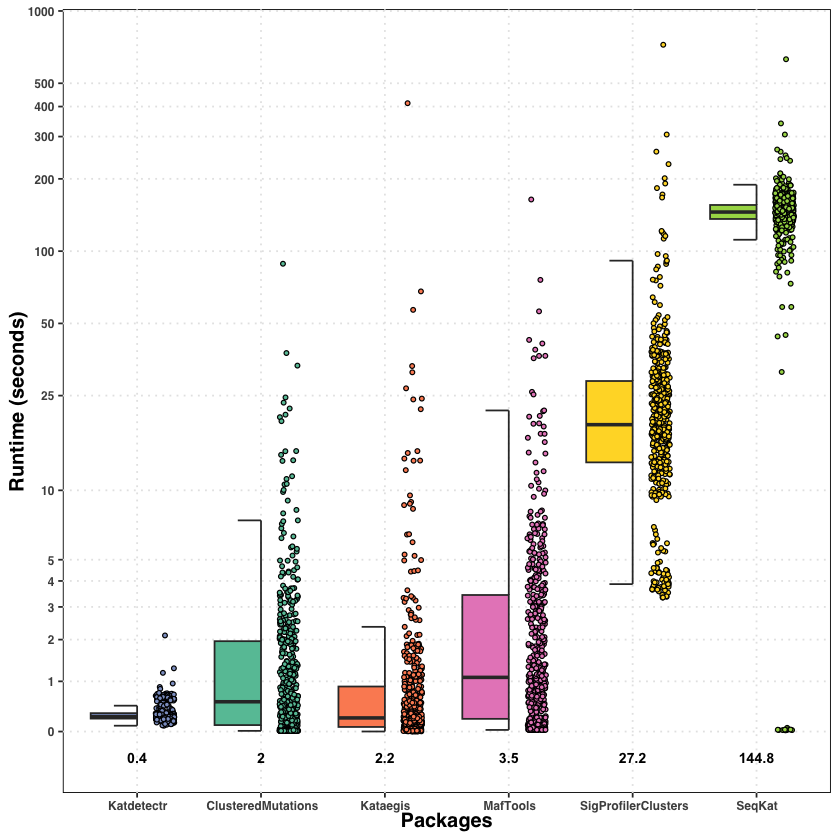

In [17]:
# facet labels
TMB.labs <- c("TMB >= 10", "0.1 >= TMB < 10", "TMB < 0.1")
names(TMB.labs) <- c("high", "mid", "low")

plotPerformancePerVariantTMB <- performancePerVariantTMBAlex |>
    tidyr::pivot_longer(
        cols = c(accuracy, TPR, TNR, F1, nMCC),
        names_to = "performanceMetric",
        values_to = "value"
    ) |>
    ggplot2::ggplot(ggplot2::aes(
        y = factor(package, levels = arrange(performancePerVariantAlex, nMCC)$package),
        x = factor(performanceMetric, levels = c("accuracy", "nMCC", "F1", "TPR", "TNR")),
        label = round(value, 4),
        fill = value
    )) +
    ggplot2::geom_tile(color = "grey25") +
    ggplot2::scale_fill_gradientn(colors = hcl.colors(20, "RdYlGn"), values = c(0, 0.5, 1), limits = c(0, 1), breaks = seq(0, 1, by = 0.25)) +
    ggplot2::ylab("Package") +
    ggplot2::xlab("Performance on WGS data split on TMB") +
    ggplot2::scale_x_discrete(position = "top") +
    ggplot2::theme(
        axis.text.x = ggplot2::element_text(angle = 0, ),
        text = ggplot2::element_text(size = 10, family = "Helvetica"),
        strip.background = ggplot2::element_blank(),
        panel.background = ggplot2::element_blank(),
        legend.title = ggplot2::element_blank()
    ) +
    ggplot2::geom_text(size = 2.9, angle = 0) +
    ggplot2::facet_grid(TMBcat ~ ., labeller = ggplot2::labeller(TMBcat = TMB.labs))

# Runtime.
colors = c('ClusteredMutations' = '#66C2A5', 'Kataegis' = '#FC8D62', 'Katdetectr' = '#8DA0CB', 'MafTools' = '#E78AC3', 'SeqKat' = '#A6D854', 'SigProfilerClusters' = '#FFD92F')
plotRunTimes.Alex <- resultsPerSampleAlex |> 
    ggplot2::ggplot(mapping = ggplot2::aes(x = factor(package, levels = arrange(performancePerSampleAlex, meanRuntime)$package), y = runTime, fill = package)) + 
    gghalves::geom_half_point_panel(size = 1, col = 'black', shape = 21) +
    gghalves::geom_half_boxplot(outlier.shape = NA) +
    ggplot2::scale_fill_manual(values = colors, guide = 'none') +
    ggplot2::scale_color_manual(values = colors, guide = 'none') +
    ggplot2::scale_y_continuous(trans = scales::pseudo_log_trans(), breaks = c(0:5, 10, 25, 50, seq(100, 500, by = 100), 1000)) +
    ggplot2::labs(y = "Runtime (seconds)", x = 'Packages') +
    ggplot2::geom_text(data = resultsPerSampleAlex %>% dplyr::group_by(package) %>% dplyr::summarise(mean = mean(runTime, na.rm = T)), ggplot2::aes(x = package, y = -.5, label = round(mean, 1)), size = 3, fontface='bold') +
    theme_Job


plotPerformancePerVariantTMB
plotRunTimes.Alex

#### Venn diagram - Overlap of kataegis-containing samples.

In [ ]:
katDetectadd <- resultsPerSampleAlex |> 
    filter(package == "Katdetectr" & (TP | FP)) |> 
    pull(sampleNames)

clusteredMutationsadd <- resultsPerSampleAlex |> 
    filter(package == "ClusteredMutations" & (TP | FP)) |> 
    pull(sampleNames)

mafToolsadd <- resultsPerSampleAlex |> 
    filter(package == "MafTools" & (TP | FP)) |> 
    pull(sampleNames)

kataegisadd <- resultsPerSampleAlex |> 
    filter(package == "Kataegis" & (TP | FP)) |> 
    pull(sampleNames)

seqkatadd <- resultsPerSampleAlex |> 
    filter(package == "SeqKat" & (TP | FP)) |> 
    pull(sampleNames)

sigProfilerClustersadd <- resultsPerSampleAlex |> 
    filter(package == "SigProfilerClusters" & (TP | FP)) |> 
    pull(sampleNames)

alexandrovAdd <- resultsPerSampleAlex |> 
    filter(kataegisInSample) |> 
    pull(sampleNames)

VennDiagram::venn.diagram(
    x = list(katDetectadd, clusteredMutationsadd, mafToolsadd, sigProfilerClustersadd, alexandrovAdd),
    category.names = c("Katdetectr", "ClusteredMutations", "MafTools", "SigProfilerClusters", "Alexandrov et al., 2013"),
    filename = "venn_diagram_kataegis_samples.png",
    output=TRUE,
    imagetype="png",
    disable.logging = TRUE,
    cat.pos = c(0, 0, -120, 120, 0),
    cat.dist = c(0.18, 0.21, 0.21, 0.25, 0.21),
    fill = c("dodgerblue", "#66C2A5", "darkorange1", "#FFD92F", "orchid3"),
    alpha = 0.50,
    col = "black",
    rotation.degree	= -6
)


![Concordance in kataegis detection in WGS dataset per sample](venn_diagram_kataegis_samples.png)

#### Venn diagram - Overlap of kataegis foci per package.

In [ ]:
findOverlappingFoci <- function(x){
    
    allFociInSample <- x
    
    Focireduced <- allFociInSample %>% 
        GenomicRanges::makeGRangesFromDataFrame(keep.extra.columns = TRUE) %>% 
        GenomicRanges::reduce(min.gapwidth = 0, ignore.strand = TRUE, with.revmap = TRUE)
    
    names(Focireduced$revmap) <- paste0(unique(allFociInSample$sampleNames), "_foci_", seq(length(Focireduced$revmap)))
    
    fociList <- lapply(Focireduced$revmap, function(i){
        allFociInSample$package[i]
    })
    
    focidf <- lapply(seq_len(length(fociList)), function(i){
        tibble(package = fociList[[i]], foci = names(fociList)[i])
    }) |> bind_rows()
    
    return(focidf)
}

alexKataegis <- alexandrovData$reportedKataegisFoci |> 
    as_tibble() |> 
    mutate(package = "Alexandrov")

resultsAlexPerFoci <- resultsAlex |> 
    filter(detectedKataegisInSample) |>  
    bind_rows(alexKataegis) |> 
    group_by(sampleNames) |> 
    group_modify(~ findOverlappingFoci(.x), .keep = TRUE) |> 
    ungroup()

katdetectrFoci <- resultsAlexPerFoci |> 
    filter(package == "Katdetectr") |> 
    pull(foci)

clusteredMutationsFoci <- resultsAlexPerFoci |> 
    filter(package == "ClusteredMutations") |> 
    pull(foci)

maftoolsFoci <- resultsAlexPerFoci |> 
    filter(package == "MafTools") |> 
    pull(foci)

kataegisPFoci <- resultsAlexPerFoci |> 
    filter(package == "Kataegis") |> 
    pull(foci)

seqKatFoci <- resultsAlexPerFoci |> 
    filter(package == "SeqKat") |> 
    pull(foci)

sigProfilerClustersFoci <- resultsAlexPerFoci |> 
    filter(package == "SigProfilerClusters") |> 
    pull(foci)

alexandrovFoci <- resultsAlexPerFoci |> 
    filter(package == "Alexandrov") |> 
    pull(foci)


VennDiagram::venn.diagram(
    x = list(katdetectrFoci, clusteredMutationsFoci, maftoolsFoci, sigProfilerClustersFoci, alexandrovFoci),
    category.names = c("Katdetectr", "ClusteredMutations", "MafTools", "SigProfilerClusters", "Alexandrov et al., 2013"),
    filename = "venn_diagram_kataegis_foci.png",
    output=T,
    imagetype="png",
    disable.logging = TRUE,
    
    cat.pos = c(0, 0, -120, 120, 0),
    cat.dist = c(0.18, 0.21, 0.21, 0.25, 0.21),
    fill = c("dodgerblue", "#66C2A5", "darkorange1", "#FFD92F", "orchid3"),
    alpha = 0.50,
    col = "black",
    rotation.degree	= -6
)

![Concordance in kataegis detection in WGS dataset per kataegis focus](venn_diagram_kataegis_foci.png)

#### Examples of kataegis foci.

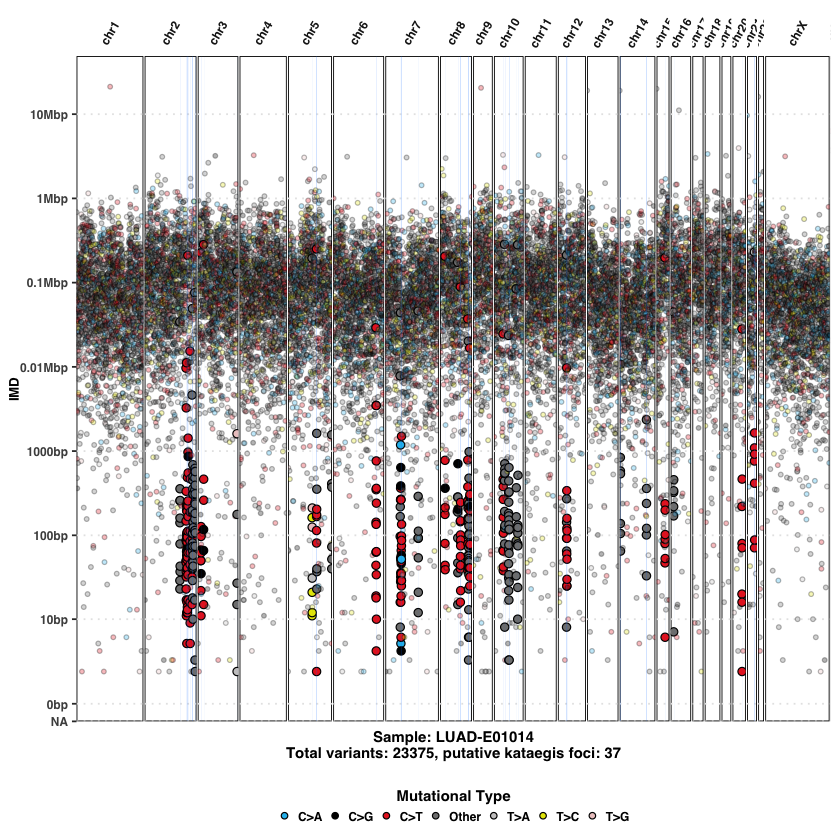

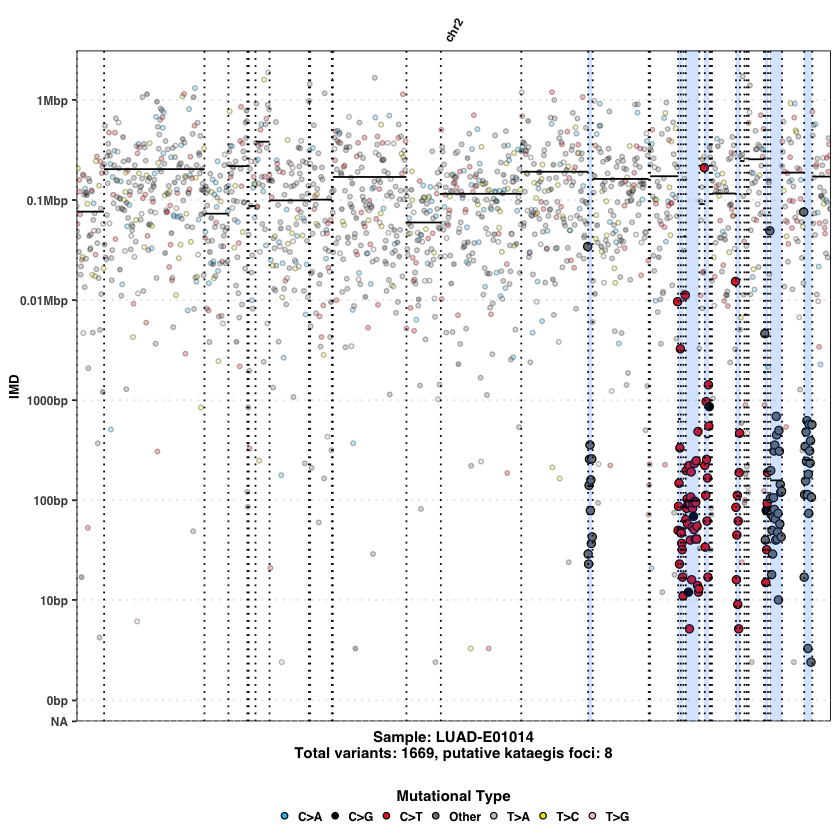

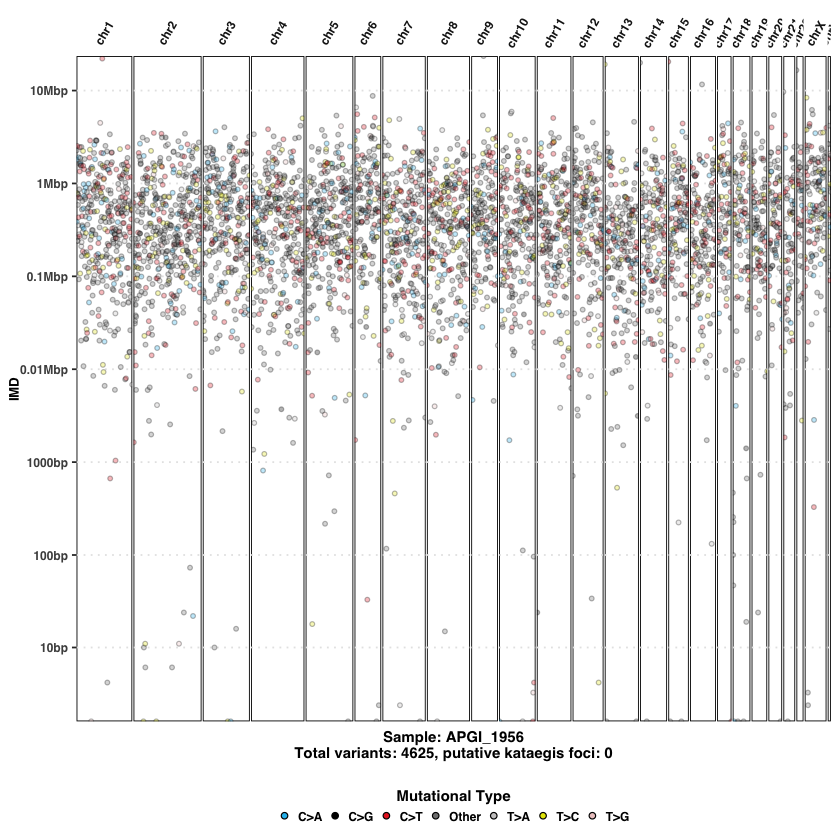

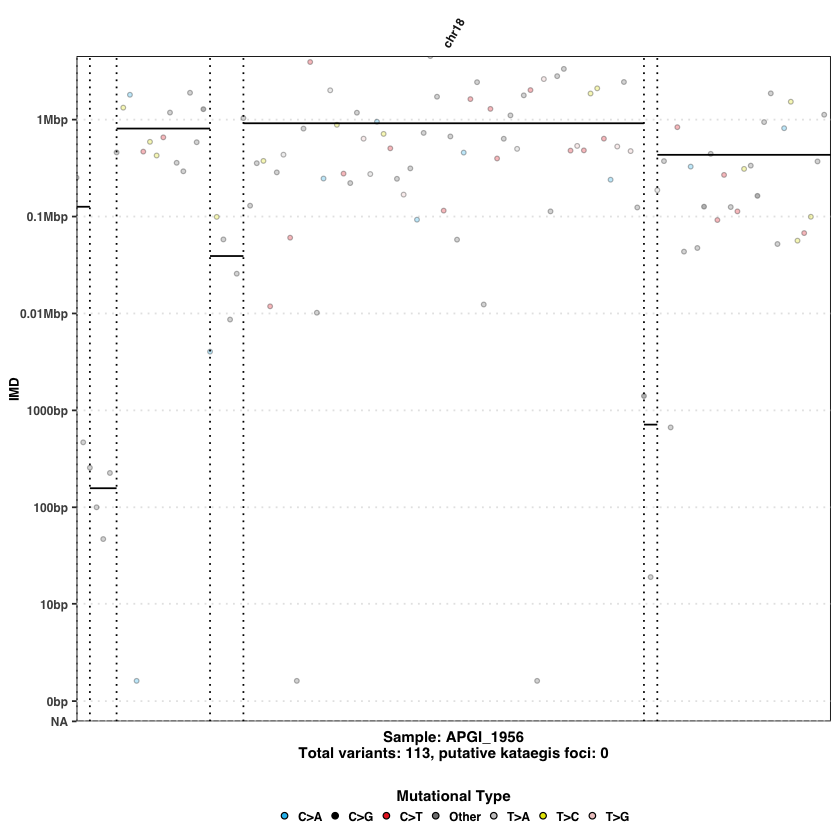

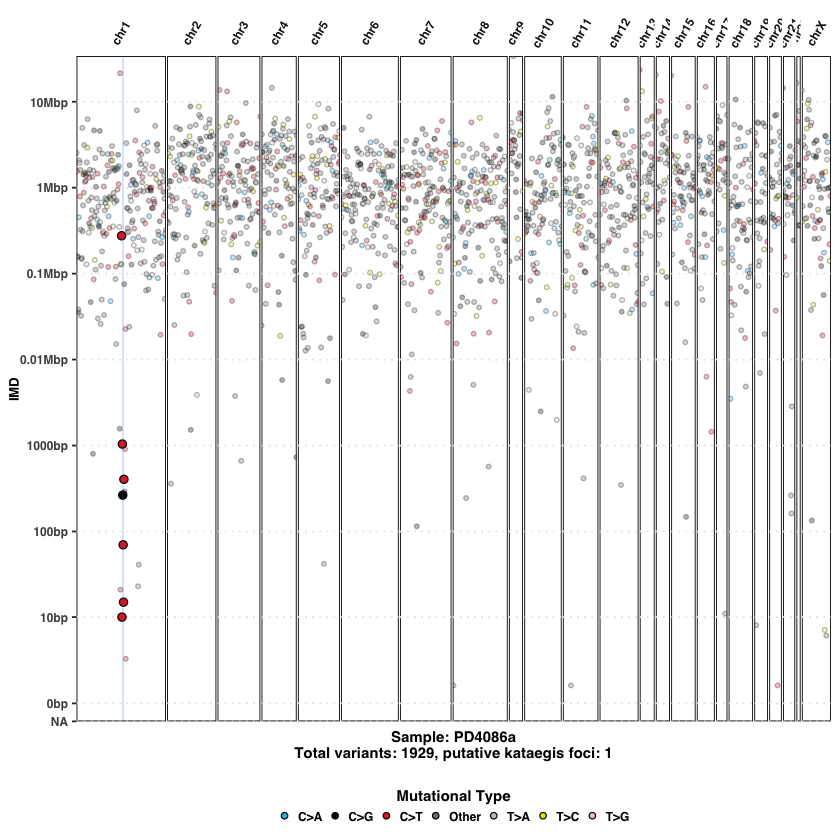

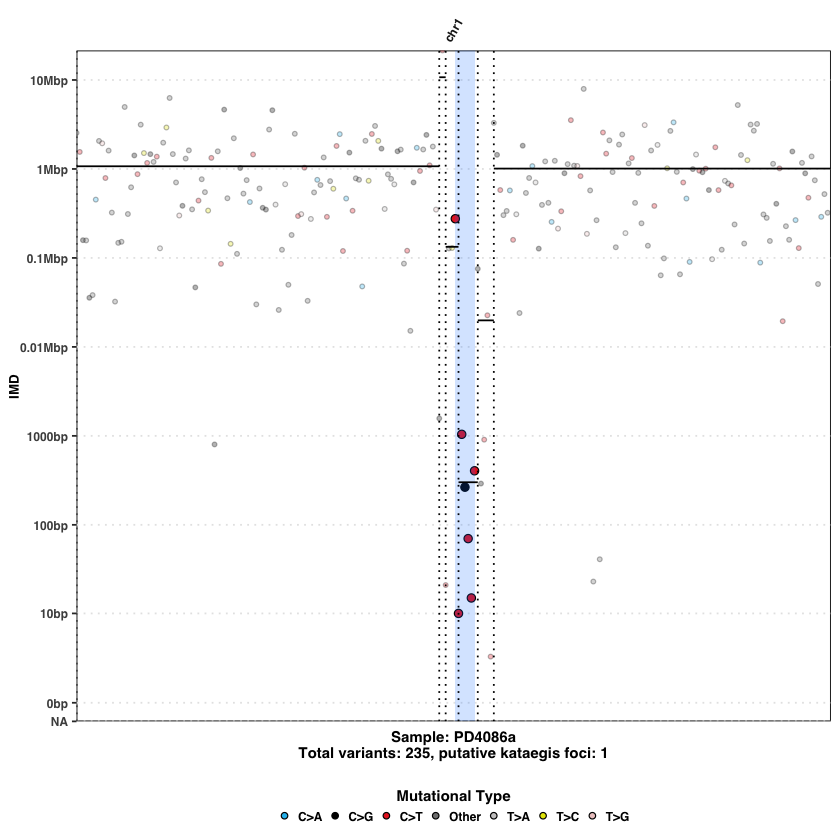

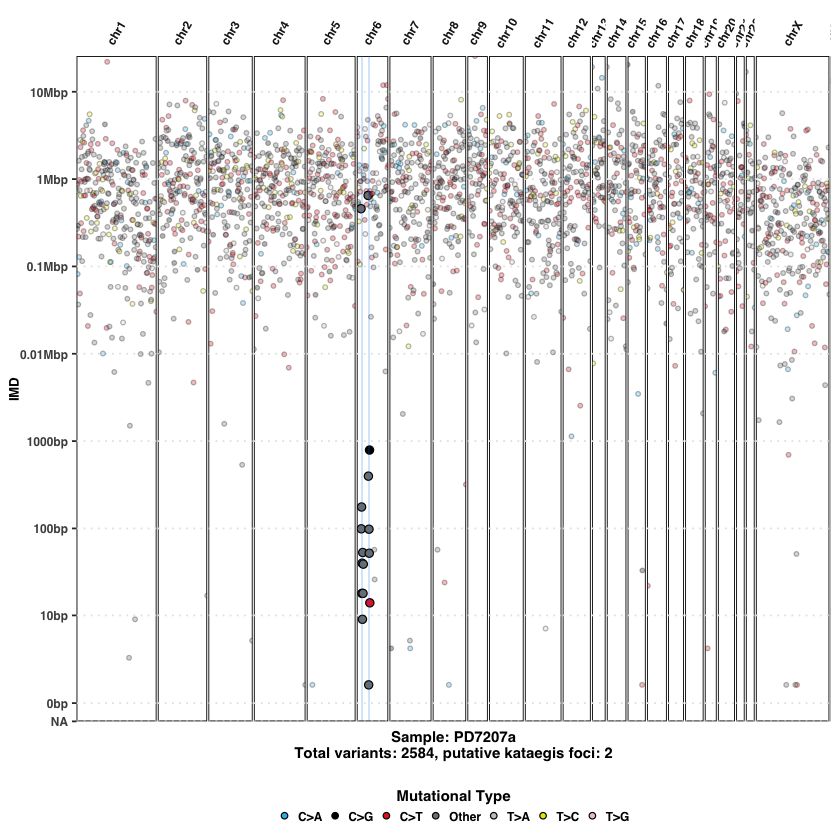

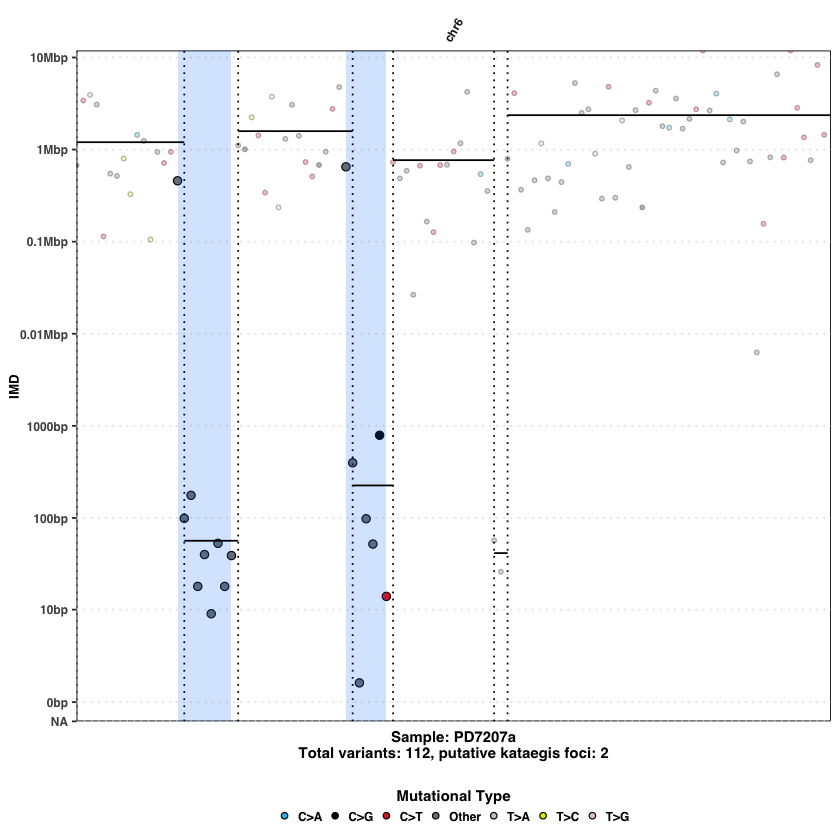

In [21]:
kdLUADE01014 <- katdetectr::detectKataegis(alexandrovData$genomicVariants$"LUAD-E01014")
rfpkdLUADE01014 <- katdetectr::rainfallPlot(kdLUADE01014)
rfpkdLUADE01014chr2 <- katdetectr::rainfallPlot(kdLUADE01014, showSequence = "chr2", showSegmentation = TRUE)

rfpkdLUADE01014
rfpkdLUADE01014chr2


kdAPGI_1956 <- katdetectr::detectKataegis(alexandrovData$genomicVariants$"APGI_1956")
rfpAPGI_1956 <- katdetectr::rainfallPlot(kdAPGI_1956)
APGI_1956chr18 <- katdetectr::rainfallPlot(kdAPGI_1956, showSequence = "chr18", showSegmentation = TRUE)

rfpAPGI_1956
APGI_1956chr18

kdPD4086a <- katdetectr::detectKataegis(alexandrovData$genomicVariants$"PD4086a")
rfpPD4086a <- katdetectr::rainfallPlot(kdPD4086a)
PD4086achr1 <- katdetectr::rainfallPlot(kdPD4086a, showSequence = "chr1", showSegmentation = TRUE)

rfpPD4086a
PD4086achr1

kdPD7207a <- katdetectr::detectKataegis(alexandrovData$genomicVariants$"PD7207a")
rfpPD7207a <- katdetectr::rainfallPlot(kdPD7207a)
rfpPD7207achr6 <- katdetectr::rainfallPlot(kdPD7207a, showSequence = "chr6", showSegmentation = TRUE)

rfpPD7207a
rfpPD7207achr6

### Overview of results for Synthetic dataset(s).

#### Descriptive overview of kataegis per TMB class.

In [22]:
descriptive_synthetic_data <- dataSynthetic$reportedKataegisFoci |> 
    filter(kataegis) |> 
    left_join(parameters, by = c("sampleNames" = "parmNames")) |> 
    group_by(sampleNames) |> 
    mutate(
        totalVariantsSample = sum(totalVariants)
    ) |> 
    ungroup() |> 
    dplyr::select(!c(start, end, totalVariants)) |> 
    distinct() |> 
    group_by(nBackgroundMuts) |> 
    summarise(
        totalVariantsTMB = sum(totalVariantsSample),
        nKataegisFociTMB = sum(nKataegisFoci)
    )

descriptive_synthetic_data

nBackgroundMuts totalVariantsTMB nKataegisFociTMB
1     25          4005             176             
2    125          4006             176             
3    249          4006             176             
4   1246          4014             176             
5   2493          4029             176             
6  12463          4077             176             
7  24925          4183             176             
8 124625          4925             176

##### Combine results into a dataframe and add columns needed for further analysis.

In [24]:
resultsSynthetic <- dplyr::bind_rows("Kataegis" = resultsSyntheticAllTools$kataegis, 
                                     "MafTools" = resultsSyntheticAllTools$maftools, 
                                     "SeqKat" = resultsSyntheticAllTools$seqkat,
                                     "ClusteredMutations" = resultsSyntheticAllTools$clusteredMutations,
                                     "Katdetectr" = resultsSyntheticAllTools$katdetectr,
                                     #"Katdetectr (AMOC)" = resultsSyntheticKatdetectrAMOC,
                                     #"Katdetectr (BinSeg)" = resultsSyntheticKatdetectrBinSeg,
                                     #"Katdetectr (SegNeigh)" = resultsSyntheticKatdetectrSegNeigh,
                                     "SigProfilerClusters" = resultsSyntheticAllTools$sigProfilerClusters,
                                     .id = "package") |> 
    # join the parameters setting used for generating the synthethic data
    dplyr::left_join(dplyr::select(parameters, parmNames, nBackgroundMuts), by = c("sampleNames" = "parmNames")) |> 
    # join the information of the generated kataegis foci
    dplyr::left_join(dplyr::select(dataSynthetic$reportedKataegisFoci, sampleNames, kataegis), by = "sampleNames", relationship = "many-to-many") |> 
    # remove duplicate rows
    dplyr::distinct() |> 
    dplyr::mutate(
        # add column which specifies if a kataegis event was detected by the method
        detectedKataegisInSample = dplyr::if_else(is.na(.data$totalVariants), FALSE, TRUE),
        # add column which specifies tumor mutational burden (TMB)
        TMB = dplyr::case_when(
            nBackgroundMuts == 25 ~ 0.1,
            nBackgroundMuts == 125 ~ 0.5,
            nBackgroundMuts == 249 ~ 1,
            nBackgroundMuts == 1246 ~ 5,
            nBackgroundMuts == 2493 ~ 10,
            nBackgroundMuts == 12463 ~ 50,
            nBackgroundMuts == 24925 ~ 100,
            nBackgroundMuts == 124625 ~ 500
        )
    ) |> 
    # make more clear that the kataegis column only specifies if the sample contains a kataegis event
    dplyr::rename(kataegisInSample = kataegis)

resultsSynthetic

package             seqnames start     end       totalVariants meanIMD 
1       Kataegis            NA       NA        NA        NA            NA      
2       Kataegis            NA       NA        NA        NA            NA      
3       Kataegis            NA       NA        NA        NA            NA      
4       Kataegis            NA       NA        NA        NA            NA      
5       Kataegis            NA       NA        NA        NA            NA      
6       Kataegis            NA       NA        NA        NA            NA      
7       Kataegis            NA       NA        NA        NA            NA      
8       Kataegis            NA       NA        NA        NA            NA      
9       Kataegis            NA       NA        NA        NA            NA      
10      Kataegis            NA       NA        NA        NA            NA      
11      Kataegis            NA       NA        NA        NA            NA      
12      Kataegis            NA       NA        NA        NA            NA      
13      Kataegis            NA       NA        NA        NA            NA      
14      Kataegis            NA       NA        NA        NA            NA      
15      Kataegis            NA       NA        NA        NA            NA      
16      Kataegis            NA       NA        NA        NA            NA      
17      Kataegis            NA       NA        NA        NA            NA      
18      Kataegis            NA       NA        NA        NA            NA      
19      Kataegis            NA       NA        NA        NA            NA      
20      Kataegis            NA       NA        NA        NA            NA      
21      Kataegis            NA       NA        NA        NA            NA      
22      Kataegis            NA       NA        NA        NA            NA      
23      Kataegis            NA       NA        NA        NA            NA      
24      Kataegis            NA       NA        NA        NA            NA      
25      Kataegis            NA       NA        NA        NA            NA      
26      Kataegis            NA       NA        NA        NA            NA      
27      Kataegis            NA       NA        NA        NA            NA      
28      Kataegis            NA       NA        NA        NA            NA      
29      Kataegis            NA       NA        NA        NA            NA      
30      Kataegis            NA       NA        NA        NA            NA      
...     ...                 ...      ...       ...       ...           ...     
2270180 SigProfilerClusters chr1     247272279 247291059 10            190.8000
2270181 SigProfilerClusters chr1     247302788 247329522 14            252.9286
2270182 SigProfilerClusters chr1     247407086 247423057 10            202.0000
2270183 SigProfilerClusters chr1     247433859 247449267 10            213.1000
2270184 SigProfilerClusters chr1     247461380 247474154  8            204.6250
2270185 SigProfilerClusters chr1     247531387 247566428 22            258.6364
2270186 SigProfilerClusters chr1     247600383 247633938 15            145.0667
2270187 SigProfilerClusters chr1     247655719 247677456 13            220.3846
2270188 SigProfilerClusters chr1     247794530 247811686  6            285.6667
2270189 SigProfilerClusters chr1     247890390 247903385  7            188.5714
2270190 SigProfilerClusters chr1     247913981 247937363 12            287.0000
2270191 SigProfilerClusters chr1     247982450 248011939 14            242.0000
2270192 SigProfilerClusters chr1     248027507 248032353  8            215.5000
2270193 SigProfilerClusters chr1     248064288 248074698 15            206.4667
2270194 SigProfilerClusters chr1     248086778 248135441 29            197.6552
2270195 SigProfilerClusters chr1     248179954 248191638  9            285.2222
2270196 SigProfilerClusters chr1     248231169 248260401 25            159.8400
2270197 SigProfilerClusters chr1     248294885 248300250  6            220.0000
2270198 

##### Calculate the performance of the kataegis detection tools regarding sample classification on the synthetic data set

In [26]:
resultsPerSample <- resultsSynthetic |> 
    # summarise if a method detected kataegis in a sample
    group_by(package, sampleNames, runTime) |> 
    summarise(
        .groups = "keep",
        # is a kataegis foci detected by the method
        detectedKataegisInSample = any(detectedKataegisInSample),
        # is there actualy a kataegis foci in that sample
        kataegisInSample = any(kataegisInSample),
        # Tumor mutational burden of sample
        TMB = unique(TMB)
    ) |> 
    ungroup() |> 
    rowwise() |> 
    # calculate confusion matrix
    mutate(
        TP = detectedKataegisInSample == TRUE & kataegisInSample == TRUE,
        FP = detectedKataegisInSample == TRUE & kataegisInSample == FALSE,
        TN = detectedKataegisInSample == FALSE & kataegisInSample == FALSE,
        FN = detectedKataegisInSample == FALSE & kataegisInSample == TRUE
    ) |> 
    ungroup()

# performance of each package over the whole dataset
performancePerSample <- resultsPerSample |> 
    group_by(package) |> 
    dplyr::group_modify(~ suppressWarnings(calculateMetrics(.x)), .keep = TRUE) |> 
    ungroup()

performancePerSampleTMB <- resultsPerSample |> 
    group_by(package, TMB) |> 
    dplyr::group_modify(~ suppressWarnings(calculateMetrics(.x)), .keep = TRUE) |> 
    ungroup()

resultsPerVariant <- resultsSynthetic |>
    dplyr::group_by(package, sampleNames) |>
    dplyr::group_modify(~ suppressWarnings(calculateConfusionVariants(.x, variantData = dataSynthetic)), .keep = TRUE) |>
    ungroup()

performancePerVariant <- resultsPerVariant |> 
    group_by(package) |> 
    dplyr::group_modify(~ suppressWarnings(calculateMetrics(.x)), .keep = TRUE) |> 
    ungroup()|>  
    arrange(desc(nMCC)) |> 
    dplyr::select(package, accuracy, nMCC, F1, TPR, TNR)

performancePerVariantTMB <- resultsPerVariant |> 
    group_by(package, TMB) |> 
    dplyr::group_modify(~ suppressWarnings(calculateMetrics(.x)), .keep = TRUE) |> 
    ungroup()

#### Visualize the MMC (synthetic)

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


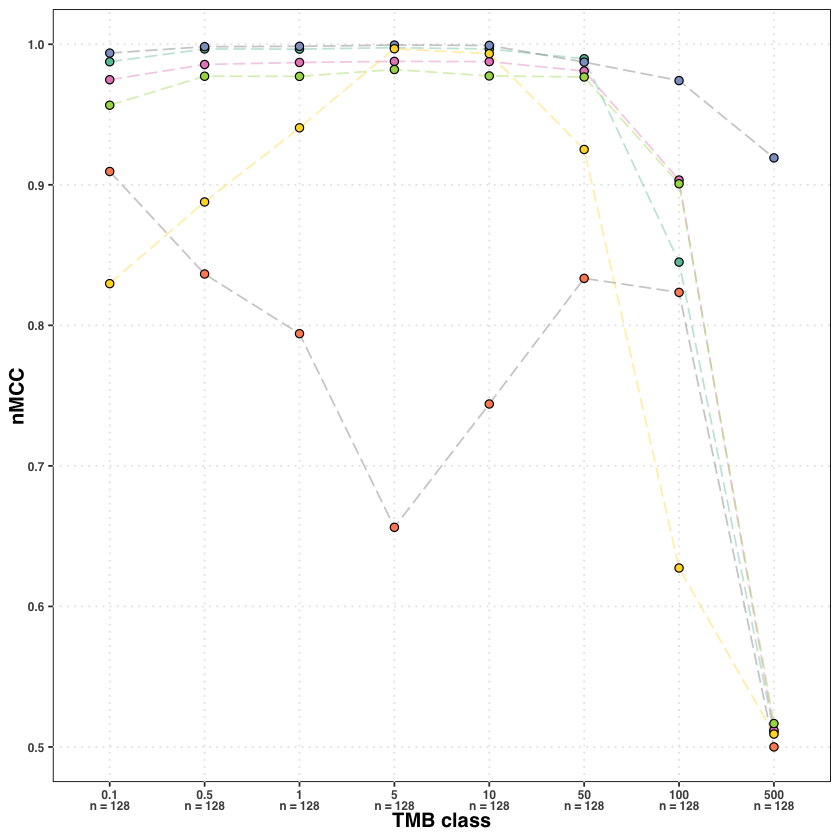

In [29]:
# use package ordering from total nMCC score on the Alexandrov dataset
levelOrderPackages <- c("Katdetect", "SeqKat", "MafTools", "SigProfilerClusters", "ClusteredMutations", "kataegis")


plotnMMC.Syn <- performancePerVariantTMB |> 
    ggplot2::ggplot(ggplot2::aes(x = factor(TMB), y = nMCC, group = package, colour = factor(package, levels = levelOrderPackages))) +
    ggplot2::geom_line(lwd = 0.5, alpha = 0.4, lty = 11) +
    ggplot2::geom_point(aes(y = nMCC, fill = package), col = 'black', shape = 21, size = 2, position = ggbeeswarm::position_quasirandom(width = .05)) +
    ggplot2::scale_fill_manual(values = colors, guide = 'none') +
    ggplot2::scale_color_manual(values = colors, guide = 'none') +
    ggplot2::scale_x_discrete(labels=c(
        "low" = "Low (TMB < 0.1)<br>n = 301", 
        "mid" = "Mid (0.1 ≥ TMB < 10)<br>n = 186",
        "high" = "High (TMB ≥ 10)<br>n = 20")
    ) +
    ggplot2::ylim(0.5, 1) +
    ggplot2::labs(x = "TMB class", y  = 'nMCC') +
    theme_Job +
    ggplot2::scale_x_discrete(labels=c(
        "0.1" = "0.1<br>n = 128",
        "0.5" = "0.5<br>n = 128", 
        "1" = "1<br>n = 128",
        "5" = "5<br>n = 128",
        "10" = "10<br>n = 128",
        "50" = "50<br>n = 128",
        "100" = "100<br>n = 128",
        "500" = "500<br>n = 128")
    )

plotnMMC.Syn

# Heatmap of kataegis detection performance

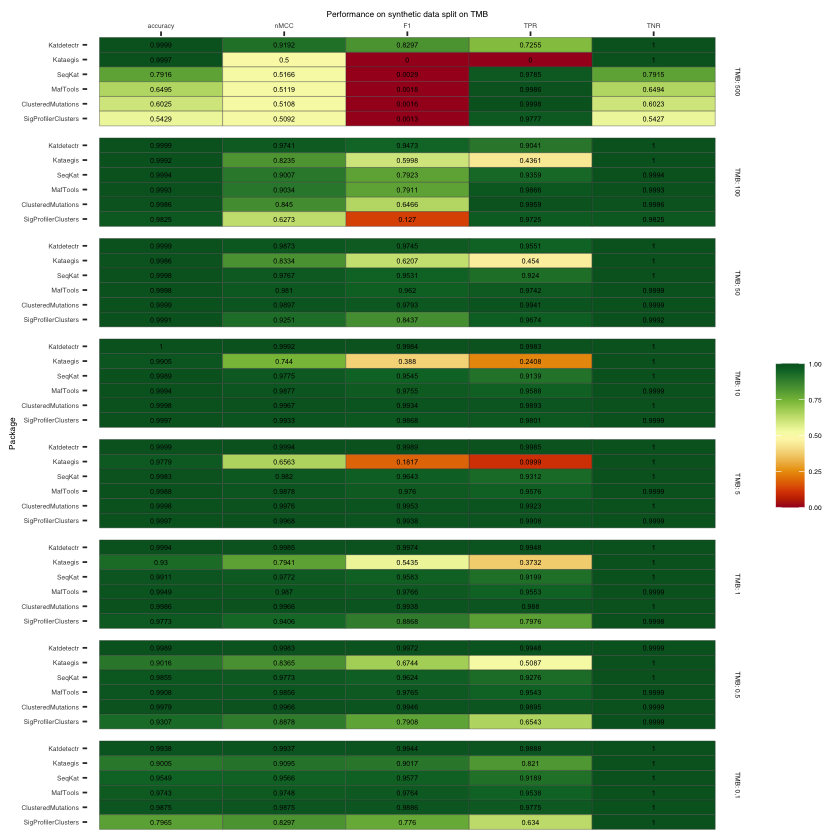

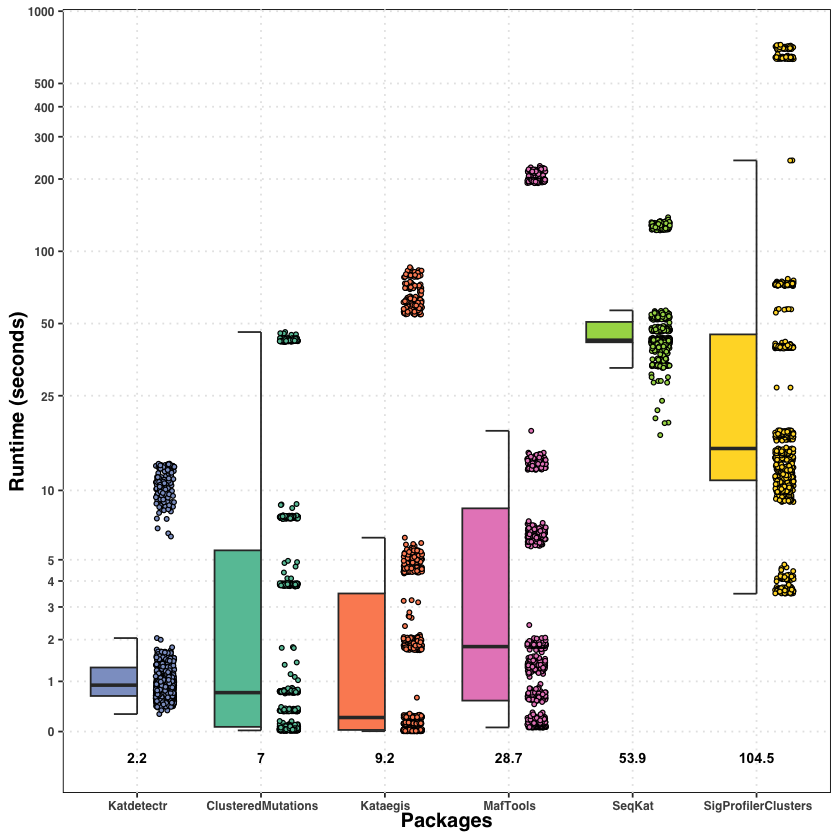

In [30]:
# facet labels
TMB.labs <- c("TMB: 500", "TMB: 100", "TMB: 50", "TMB: 10", "TMB: 5", "TMB: 1", "TMB: 0.5", "TMB: 0.1")
names(TMB.labs) <- c(500, 100, 50, 10, 5, 1, 0.5, 0.1)

plotPerformancePerVariantTMB <- performancePerVariantTMB |> 
    tidyr::pivot_longer(
        cols = c(accuracy, TPR, TNR, F1, nMCC),
        names_to = "performanceMetric",
        values_to = "value"
    ) |> 
    mutate(TMB = factor(TMB, levels = c(500, 100, 50, 10, 5, 1, 0.5, 0.1))) |> 
    ggplot2::ggplot(aes(y = factor(package, levels = arrange(performancePerVariant, nMCC)$package), 
                        x = factor(performanceMetric, levels = c("accuracy", "nMCC", "F1", "TPR", "TNR")), 
                        label = round(value, 4), 
                        fill = value)) +
    ggplot2::geom_tile(color = 'grey25') +
    scale_fill_gradientn(colors = hcl.colors(20, "RdYlGn"), values = c(0,0.5,1)) +
    ggplot2::ylab("Package") +
    ggplot2::xlab("Performance on synthetic data split on TMB") +
    scale_x_discrete(position = "top") +
    theme(
        axis.text.x = element_text(angle = 0, ),
        text = ggplot2::element_text(size=5, family='Helvetica'),
        strip.background = ggplot2::element_blank(),
        panel.background = element_blank(),
        legend.title = element_blank()
    ) +
    ggplot2::geom_text(size = 1.5, angle = 0) +
    facet_grid(TMB ~ ., labeller = labeller(TMB = rev(TMB.labs)))

colors = c('ClusteredMutations' = '#66C2A5', 'Kataegis' = '#FC8D62', 'Katdetectr' = '#8DA0CB', 'MafTools' = '#E78AC3', 'SeqKat' = '#A6D854', 'SigProfilerClusters' = '#FFD92F')
plotRunTimes.Syn <- resultsPerSample |> 
    ggplot2::ggplot(mapping = ggplot2::aes(x = factor(package, levels = arrange(performancePerSample, meanRuntime)$package), y = runTime, fill = package)) + 
    gghalves::geom_half_point_panel(size = 1, col = 'black', shape = 21) +
    gghalves::geom_half_boxplot(outlier.shape = NA) +
    ggplot2::scale_fill_manual(values = colors, guide = 'none') +
    ggplot2::scale_color_manual(values = colors, guide = 'none') +
    ggplot2::scale_y_continuous(trans = scales::pseudo_log_trans(), breaks = c(0:5, 10, 25, 50, seq(100,500,by = 100), 1000)) +
    ggplot2::labs(y = "Runtime (seconds)", x = 'Packages') +
    ggplot2::geom_text(data = resultsPerSample %>% dplyr::group_by(package) %>% dplyr::summarise(mean = mean(runTime, na.rm = T)), ggplot2::aes(x = package, y = -.5, label = round(mean, 1)), size = 3, fontface='bold') +
    theme_Job


plotPerformancePerVariantTMB
plotRunTimes.Syn

#### Examples (Synthetic)

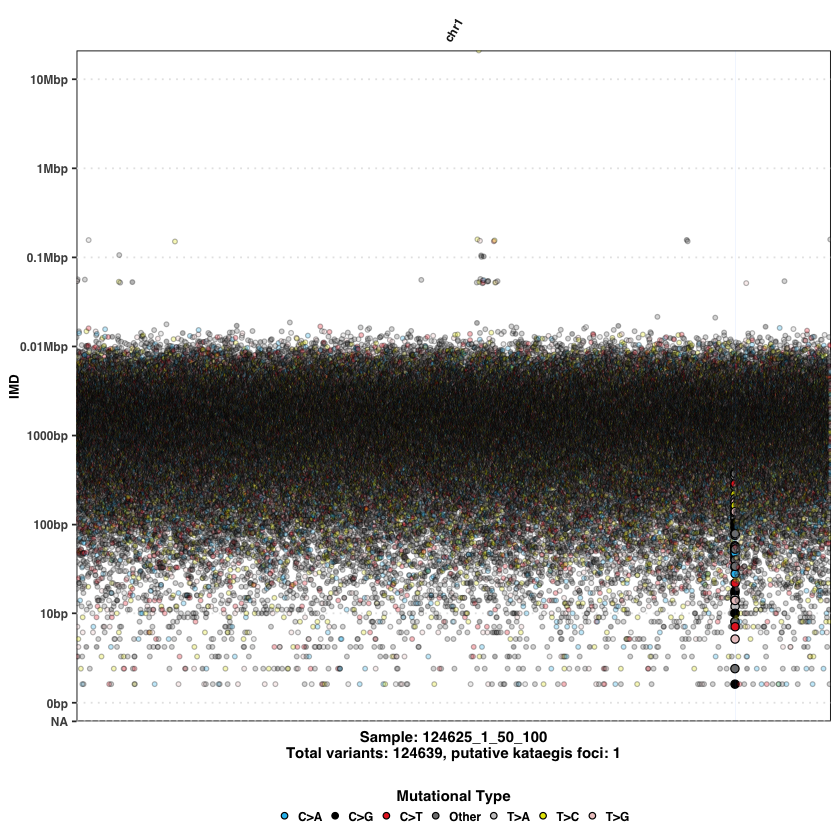

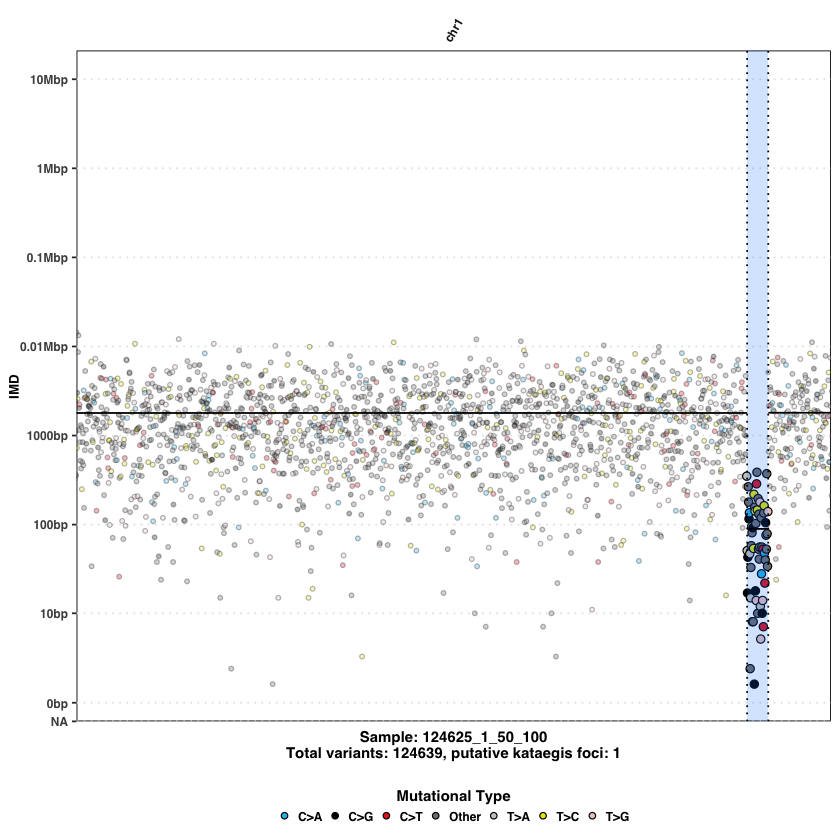

In [31]:
kd124625_1_50_100 <- katdetectr::detectKataegis(dataSynthetic$genomicVariants$`124625_1_50_100`)
rfp124625_1_50_100 <- katdetectr::rainfallPlot(kd124625_1_50_100)
rfp124625_1_50_100zoom <- katdetectr::rainfallPlot(kd124625_1_50_100, showSegmentation = TRUE) + coord_cartesian(xlim = c(107000, 109000))

rfp124625_1_50_100
rfp124625_1_50_100zoom

## Session information


In [32]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRlapack.dylib

locale:
[1] C

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] maftools_2.14.0             kataegis_0.99.2            
 [3] ClusteredMutations_1.0.1    seriation_1.4.2            
 [5] doMC_1.3.8                  SeqKat_0.0.8               
 [7] doParallel_1.0.17           iterators_1.0.14           
 [9] foreach_1.5.2               pbapply_1.7-0              
[11] VariantAnnotation_1.44.1    Rsamtools_2.14.0           
[13] Biostrings_2.66.0           XVector_0.38.0             
[15] SummarizedExperiment_1.28.0 GenomicRanges_1.50.2       
[17] GenomeInfoDb_1.34.9 